In [1]:
import socket
print(socket.gethostname())

import sys
sys.path.insert(0,'/geode2/home/u080/sheybani/BigRed200/spenv/lib/python3.10/site-packages')
print(sys.path)

import torch
print(torch.cuda.is_available())

login1
['/geode2/home/u080/sheybani/BigRed200/spenv/lib/python3.10/site-packages', '/geode2/home/u080/sheybani/BigRed200/github/transformprediction/models', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python310.zip', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10/lib-dynload', '', '/N/soft/sles15/deeplearning/Python-3.10.2/lib/python3.10/site-packages']
False


In [2]:
# Load the Basic files

import numpy as np
import torch, torchvision
from torchvision.transforms import ToTensor, Normalize, ConvertImageDtype
from torchvision import transforms as T
from torch import nn
from torch.nn import functional as F
import os
import random
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [3]:
vid_root = '/N/slate/sheybani/ego4ddata/pp_images/'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# fnames = os.listdir(vid_root)
fnames = []
for froot, _, fname in os.walk(vid_root):
    if len(fname)>0:
        new_names = [os.path.join(froot,item) for item in fname]
        fnames +=new_names
# def get_picnum(fpath):
#     return int(fpath.split('/')[-1].split('.')[0])
fnames.sort()#key=get_picnum)

In [5]:
# # get mean, std of the colors
# s_rate = 2
# transform0 = T.Compose([T.ConvertImageDtype(torch.float32)])
# train_data_te = TimeContrastiveTorchDataset(train_data, pdif=1, ndif=5*s_rate,
#                                 transform=transform0)

# means = []
# stds = []

# n_subset = 1000
# rand_idx = np.random.randint(len(train_data_te), size=n_subset)
# t0 = time.time()
# for i in range(n_subset):
#     img, _,_ = train_data_te[rand_idx[i]]
#     means.append(img.view(3,-1).mean(dim=1).numpy())
    
#     if i%100==0:
#         print('i=',i)

# print(time.time()-t0)
# mean = np.asarray(means).mean(axis=0)
# print('mean=',mean)

# mean_t = torch.FloatTensor(mean).view(3,1)
# sse = []
# for i in range(n_subset):
#     img, _,_ = train_data_te[rand_idx[i]]
#     sse.append(((img.view(3,-1)-mean_t)**2).mean(dim=1).numpy())
# #     means.append(img.view(3,-1).mean(dim=1).numpy())
# #     stds.append(img.view(3,-1).std(dim=1).numpy())
# #     stds.append(img.std(dim=1).std(dim=1).numpy())
    
#     if i%100==0:
#         print('i=',i)
# sse = np.asarray(sse)
# std = np.sqrt(sse.mean(axis=0))
# print('std=',std)

In [6]:
# Create a Dataloader for the Time contrastive loss.
s_rate = 2

mean, std = (0.413, 0.373, 0.340), (0.251, 0.236, 0.235)
# transforms_ego4d = nn.Sequential(
#     ConvertImageDtype(torch.float32),
#     Normalize(mean,std),
#     )

transforms_ego4d = nn.Sequential(
    ConvertImageDtype(torch.float32),
    Normalize(mean,std),
    )

#     [
#      NormalizeVideo(mean, std),
#      Lambda(lambda x: torch.permute(x, (1,2,3,0)))
#      ])


class TimeContrastiveTorchDataset(torch.utils.data.Dataset):
    def __init__(self, fnames, pdif=1, ndif=5*s_rate, transform=None):
#         self.root = root
        self.fnames = fnames
        self.transform = transform
        self.pdif = pdif
        self.ndif = ndif #depends on the activity (perhaps some inherent period of the chore being done) 
        # 5*s_rate seems like a good number for the activities in ego4d
        
    def __getitem__(self, idx):
        # assuming idx is an int
        anchor_path = self.fnames[idx]
        pos_path = self.fnames[idx-self.pdif] # has an incorrect edge case at idx being the first in the folder,
        # which happens very rarely given that there are ~500 images in each folder
#         neg_path = random.choice(self.fnames)
        neg_path = self.fnames[idx-self.ndif]
        
        a = torchvision.io.read_image(anchor_path)
        p = torchvision.io.read_image(pos_path)
        n = torchvision.io.read_image(neg_path)
        
        if self.transform is not None:
            a,p,n = self.transform(a), self.transform(p), self.transform(n)
            
        return torch.stack((a,p,n))
    
    def __len__(self):
        return len(self.fnames)

train_data = fnames
train_data_te = TimeContrastiveTorchDataset(train_data, pdif=1, ndif=5*s_rate,
                                transform=transforms_ego4d)
train_dataloader = torch.utils.data.DataLoader(
    train_data_te, batch_size=256, shuffle=True, pin_memory=True, num_workers=2)

In [7]:
#%% Instantiation
xmodel = torchvision.models.resnet18(pretrained=False)
hdim = 1000
# seq_len = xclips.shape[1]
xmodel.fc = nn.Linear(512, hdim)
# nn.init.kaiming_normal_(xmodel.fc.weight, a=0, mode='fan_in', nonlinearity='leaky_relu')

xmodel.float()
xmodel.to(device)
xmodel.train()

# optimizer = torch.optim.Adam([
#     {'params': xmodel.shared_encoder.parameters()},
#     {'params': xmodel.ventral.parameters(), 'lr': 1e-3},
#     {'params': xmodel.dorsal.parameters(), 'lr': 1e-4}
#     ], lr=1e-1, weight_decay=0, amsgrad=False)

optimizer = torch.optim.Adam(xmodel.parameters(), lr=1e-3, 
                            weight_decay=0)

# optimizer = torch.optim.SGD(xmodel.parameters(), lr=1e-2, 
#                             weight_decay=1e-4)
    
# optimizer_name="SGD":optimizer_hparams={
    # "lr": 0.1,"momentum": 0.9,"weight_decay": 1e-4})  
# triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, reduction='mean')
# cosine_sim = nn.CosineSimilarity(dim=0)
# cosine_sim_f = lambda inp1,inp2: 1-cosine_sim(inp1,inp2)
cosine_sim_f = lambda x, y: 1.0 - F.cosine_similarity(x, y)
triplet_loss = nn.TripletMarginWithDistanceLoss(distance_function=cosine_sim_f, margin=0.2, reduction='mean')


In [8]:
def to_static(img_seq):
    n_samples, seq_len, *other_dims = img_seq.shape
    return img_seq.reshape((n_samples*seq_len, *other_dims))

def to_seq(img_flt, seq_len):
    n_samplesXseq_len, *other_dims = img_flt.shape
    n_samples = int(n_samplesXseq_len/seq_len)
    return img_flt.view((n_samples, seq_len, *other_dims))

def to_batchseq(img_flt, seq_len):
    n_samplesXseq_len, *other_dims = img_flt.shape
    n_samples = int(n_samplesXseq_len/seq_len)
    return img_flt.view((seq_len, n_samples, *other_dims))


In [101]:
seq_len = 3
loss_list = []
iteration_list = []

for i, triplet in enumerate(tqdm(train_dataloader)):
    if i>=10:
        break
    xmodel.train()
    optimizer.zero_grad()
    
    triplet = triplet.to(device)
    out = xmodel(to_static(triplet))
    ytt = to_seq(out, seq_len)
    a = ytt[:,0,...]
    p = ytt[:,1,...]
    n = ytt[:,2,...]
    
    cpc_loss = triplet_loss(a, p, n)
    loss = cpc_loss
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.data.item())
    iteration_list.append(i)
        
    if i%1==0:
        print('Iteration: {}  Train Loss: {}  '.format(i, loss.data.item()))
    


  0%|                                         | 1/899 [00:27<6:48:09, 27.27s/it]

Iteration: 0  Train Loss: 0.19011786580085754  


  0%|                                         | 2/899 [00:27<2:51:09, 11.45s/it]

Iteration: 1  Train Loss: 0.1728968620300293  


  0%|▏                                        | 3/899 [00:52<4:25:38, 17.79s/it]

Iteration: 2  Train Loss: 0.15940535068511963  


  0%|▏                                        | 4/899 [00:53<2:42:46, 10.91s/it]

Iteration: 3  Train Loss: 0.1368188112974167  


  1%|▏                                        | 5/899 [01:18<3:58:01, 15.98s/it]

Iteration: 4  Train Loss: 0.1302545964717865  


  1%|▎                                        | 6/899 [01:18<2:38:48, 10.67s/it]

Iteration: 5  Train Loss: 0.1475277841091156  


  1%|▎                                        | 7/899 [01:43<3:46:38, 15.25s/it]

Iteration: 6  Train Loss: 0.13451826572418213  


  1%|▎                                        | 8/899 [01:44<2:38:27, 10.67s/it]

Iteration: 7  Train Loss: 0.15923263132572174  


  1%|▍                                        | 9/899 [02:11<3:56:40, 15.96s/it]

Iteration: 8  Train Loss: 0.13428345322608948  


  1%|▍                                       | 10/899 [02:12<2:45:07, 11.14s/it]

Iteration: 9  Train Loss: 0.12789161503314972  


  1%|▍                                       | 10/899 [02:20<3:28:07, 14.05s/it]


KeyboardInterrupt: 

In [50]:
# Additional information
EPOCH = 1
PATH = "/N/slate/sheybani/tmp_dir/trainedmodels/ego4d_cpc0/model_may2_1610.pt"
LOSS = loss_list[-1]

torch.save({
            'epoch': EPOCH,
            'model_state_dict': xmodel.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html

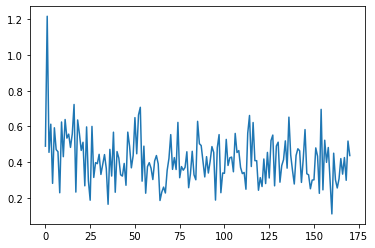

In [48]:
plt.plot(iteration_list, loss_list)

In [10]:
PATH = "/N/slate/sheybani/tmp_dir/trainedmodels/ego4d_cpc0/model_may2_1610.pt"

checkpoint = torch.load(PATH, map_location=torch.device('cpu'))
xmodel.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

xmodel.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

similarity to pos =  tensor(0.9953) similarity to neg = tensor(0.9891)
similarity to pos =  tensor(0.9911) similarity to neg = tensor(0.9848)
similarity to pos =  tensor(0.9996) similarity to neg = tensor(0.9943)
similarity to pos =  tensor(0.9977) similarity to neg = tensor(0.9808)
similarity to pos =  tensor(0.9925) similarity to neg = tensor(0.9644)
similarity to pos =  tensor(0.9790) similarity to neg = tensor(0.9649)


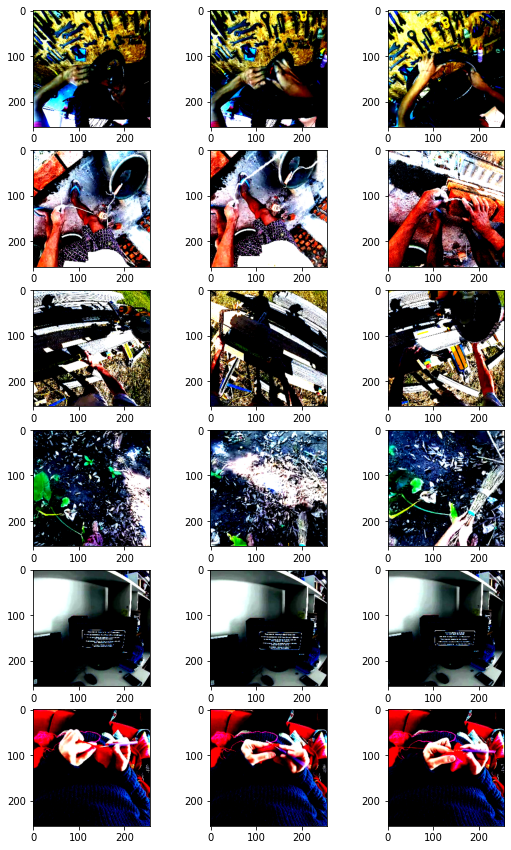

In [96]:
rand_idx = np.random.randint(triplet.shape[0], size=6)
samples = triplet[rand_idx,...]
outputs = ytt[rand_idx].detach().cpu()#.numpy()
pdist = nn.CosineSimilarity(dim=0) #nn.PairwiseDistance(p=2)

fig,ax = plt.subplots(6,3, figsize=(9,15))
for j in range(6):
    for i in range(3):
        ax[j,i].imshow(torch.permute(samples[j,i,...], (1,2,0)))
    pos_dist = pdist(outputs[j,0,:],outputs[j,1,:])
    neg_dist = pdist(outputs[j,0,:],outputs[j,2,:])
    print('similarity to pos = ', pos_dist, 'similarity to neg =',neg_dist)


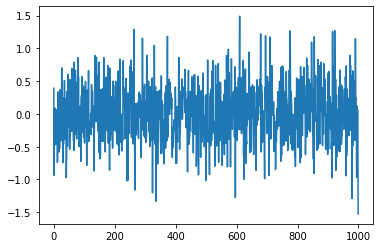

In [71]:
plt.plot(outputs[0,0,:])